# Control Flow Graph

The code in this notebook helps with obtaining the control flow graph of python functions.

**Prerequisites**

* This notebook needs some understanding on advanced concepts in Python, notably 
    * classes

## Control Flow Graph

The class `PyCFG` allows one to obtain the control flow graph.

```Python
from ControlFlow import PyCFG

cfg = PyCFG.gen_cfg(function_source)
graph = PyCFG.to_graph(cfg)
```


In [1]:
import fuzzingbook_utils

In [2]:
import ast
import re
import astunparse
from graphviz import Source, Graph, Digraph

### Registry

In [3]:
REGISTRY_IDX = 0

In [4]:
REGISTRY = {}

In [5]:
def get_registry_idx():
    global REGISTRY_IDX
    v = REGISTRY_IDX
    REGISTRY_IDX += 1
    return v

In [6]:
def reset_registry():
    global REGISTRY_IDX
    global REGISTRY
    REGISTRY_IDX = 0
    REGISTRY = {}

In [7]:
def register_node(node):
    node.rid = get_registry_idx()
    REGISTRY[node.rid] = node

### CFGNode
We start with the `CFGNode` representing each node in the control flow graph.

In [8]:
class CFGNode(dict):
    def __init__(self, parents=[], ast=None):
        assert type(parents) is list
        register_node(self)
        self.parents = parents
        self.ast_node = ast
        self.update_children(parents)  # requires self.rid
        self.children = []
        self.calls = []
        self._child_annotation = None  # one shot annotation for branches (if)
        self.child_node_annotations = {}

    def set_oneshot_annotation(self, a):
        self._child_annotation = a
        
    def i(self):
        return str(self.rid)

    def update_children(self, parents):
        for p in parents:
            p.add_child(self)

    def add_child(self, c):
        if c not in self.children:
            self.children.append(c)
        # the current annotation is in self._child_annotation
        # it is a oneshot annotation: essentially True/False
        if self._child_annotation is not None:
            # there can be only one annotation to an edge to c.rid
            self.child_node_annotations[c.rid] = self._child_annotation
            self._child_annotation = None

    def lineno(self):
        return self.ast_node.lineno if hasattr(self.ast_node, 'lineno') else 0

    def __str__(self):
        return "id:%d line[%d] parents: %s : %s %s" % (
            self.rid, self.lineno(), str([p.rid for p in self.parents]),
            self.source())

    def __repr__(self):
        return str(self)

    def __eq__(self, other):
        return self.rid == other.rid

    def __neq__(self, other):
        return self.rid != other.rid

    def set_parents(self, p):
        self.parents = p

    def add_parent(self, p):
        if p not in self.parents:
            self.parents.append(p)

    def add_parents(self, ps):
        for p in ps:
            self.add_parent(p)

    def add_calls(self, func):
        self.calls.append(func)

    def source(self):
        return astunparse.unparse(self.ast_node).strip()

    def to_json(self):
        return {
            'id': self.rid,
            'parents': [p.rid for p in self.parents],
            'children': [c.rid for c in self.children],
            'calls': self.calls,
            'at': self.lineno(),
            'ast': self.source()
        }

In [9]:
REGISTRY_IDX = 0

In [10]:
REGISTRY = {}

In [11]:
def get_registry_idx():
    global REGISTRY_IDX
    v = REGISTRY_IDX
    REGISTRY_IDX += 1
    return v

In [12]:
def reset_registry():
    global REGISTRY_IDX
    global REGISTRY
    REGISTRY_IDX = 0
    REGISTRY = {}

In [13]:
def register_node(node):
    node.rid = get_registry_idx()
    REGISTRY[node.rid] = node

### PyCFG

Next, the `PyCFG` class which is responsible for parsing, and holding the graph.

In [14]:
class PyCFG:
    def __init__(self):
        self.founder = CFGNode(
            parents=[], ast=ast.parse('start').body[0])  # sentinel
        self.founder.ast_node.lineno = 0
        self.functions = {}
        self.functions_node = {}

    def parse(self, src):
        return ast.parse(src)

    def walk(self, node, myparents, annot=None):
        fname = "on_%s" % node.__class__.__name__.lower()
        if hasattr(self, fname):
            fn = getattr(self, fname)
            v = fn(node, myparents, annot)
            return v
        else:
            return myparents

    def on_module(self, node, myparents, annot):
        """
        Module(stmt* body)
        """
        # each time a statement is executed unconditionally, make a link from
        # the result to next statement
        p = myparents
        for n in node.body:
            p = self.walk(n, p)
        return p

    def on_assign(self, node, myparents, annot):
        """
        Assign(expr* targets, expr value)
        TODO: AugAssign(expr target, operator op, expr value)
        -- 'simple' indicates that we annotate simple name without parens
        TODO: AnnAssign(expr target, expr annotation, expr? value, int simple)
        """
        if len(node.targets) > 1:
            raise NotImplemented('Parallel assignments')

        p = [CFGNode(parents=myparents, ast=node)]
        p = self.walk(node.value, p)

        return p

    def on_pass(self, node, myparents, annot):
        return [CFGNode(parents=myparents, ast=node)]

    def on_break(self, node, myparents, annot):
        parent = myparents[0]
        while not hasattr(parent, 'exit_nodes'):
            # we have ordered parents
            parent = parent.parents[0]

        assert hasattr(parent, 'exit_nodes')
        p = CFGNode(parents=myparents, ast=node)

        # make the break one of the parents of label node.
        parent.exit_nodes.append(p)

        # break doesnt have immediate children
        return []

    def on_continue(self, node, myparents, annot):
        parent = myparents[0]
        while not hasattr(parent, 'exit_nodes'):
            # we have ordered parents
            parent = parent.parents[0]
        assert hasattr(parent, 'exit_nodes')
        p = CFGNode(parents=myparents, ast=node)

        # make continue one of the parents of the original test node.
        parent.add_parent(p)

        # return the parent because a continue is not the parent
        # for the just next node
        return []

    def on_for(self, node, myparents, annot):
        # node.target in node.iter: node.body
        # TODO: The For loop in python (no else) can be translated
        # as follows:
        # 
        # for a in iterator:
        #      mystatements
        #
        # __iv = iter(iterator)
        # while __iv.__length_hint() > 0:
        #     a = next(__iv)
        #     mystatements
        
        _test_node = CFGNode(
            parents=myparents,
            ast=ast.parse('_for: True if %s else False' % astunparse.unparse(
                node.iter).strip()).body[0])
        ast.copy_location(_test_node.ast_node, node)

        # we attach the label node here so that break can find it.
        _test_node.exit_nodes = []
        test_node = self.walk(node.iter, [_test_node])

        test_node[0].set_oneshot_annotation('T')
        extract_node = CFGNode(
            parents=[_test_node],
            ast=ast.parse('%s = %s.shift()' %
                          (astunparse.unparse(node.target).strip(),
                           astunparse.unparse(node.iter).strip())).body[0])
        ast.copy_location(extract_node.ast_node, _test_node.ast_node)

        # now we evaluate the body, one at a time.
        p1 = [extract_node]
        for n in node.body:
            p1 = self.walk(n, p1)

        # the test node is looped back at the end of processing.
        _test_node.add_parents(p1)

        test_node[0].set_oneshot_annotation('F')
        return _test_node.exit_nodes + test_node

    def on_while(self, node, myparents, annot):
        # For a while, the earliest parent is the node.test
        _test_node = CFGNode(
            parents=myparents,
            ast=ast.parse(
                '_while: %s' % astunparse.unparse(node.test).strip()).body[0])
        ast.copy_location(_test_node.ast_node, node.test)
        _test_node.exit_nodes = []
        test_node = self.walk(node.test, [_test_node])

        # we attach the label node here so that break can find it.

        # now we evaluate the body, one at a time.
        assert len(test_node) == 1
        test_node[0].set_oneshot_annotation('T')
        p1 = test_node
        for n in node.body:
            p1 = self.walk(n, p1)

        # the test node is looped back at the end of processing.
        _test_node.add_parents(p1)

        # link label node back to the condition.
        test_node[0].set_oneshot_annotation('F')
        return _test_node.exit_nodes + test_node

    def on_if(self, node, myparents, annot):
        _test_node = CFGNode(
            parents=myparents,
            ast=ast.parse(
                '_if: %s' % astunparse.unparse(node.test).strip()).body[0])
        ast.copy_location(_test_node.ast_node, node.test)
        test_node = self.walk(node.test, [_test_node])
        assert len(test_node) == 1
        g1 = test_node
        test_node[0].set_oneshot_annotation('T')
        for n in node.body:
            g1 = self.walk(n, g1)
        g2 = test_node
        test_node[0].set_oneshot_annotation('F')
        for n in node.orelse:
            g2 = self.walk(n, g2)
        return g1 + g2

    def on_binop(self, node, myparents, annot):
        left = self.walk(node.left, myparents)
        right = self.walk(node.right, left)
        return right

    def on_compare(self, node, myparents, annot):
        left = self.walk(node.left, myparents)
        right = self.walk(node.comparators[0], left)
        return right

    def on_unaryop(self, node, myparents, annot):
        return self.walk(node.operand, myparents)

    def on_call(self, node, myparents, annot):
        def get_func(node):
            if type(node.func) is ast.Name:
                mid = node.func.id
            elif type(node.func) is ast.Attribute:
                mid = node.func.attr
            elif type(node.func) is ast.Call:
                mid = get_func(node.func)
            else:
                raise Exception(str(type(node.func)))
            return mid
            #mid = node.func.value.id

        p = myparents
        for a in node.args:
            p = self.walk(a, p)
        mid = get_func(node)
        myparents[0].add_calls(mid)

        # these need to be unlinked later if our module actually defines these
        # functions. Otherwsise we may leave them around.
        # during a call, the direct child is not the next
        # statement in text.
        for c in p:
            c.calllink = 0
        return p

    def on_expr(self, node, myparents, annot):
        p = [CFGNode(parents=myparents, ast=node)]
        return self.walk(node.value, p)

    def on_return(self, node, myparents, annot):
        if type(myparents) is tuple:
            parent = myparents[0][0]
        else:
            parent = myparents[0]

        val_node = self.walk(node.value, myparents)
        # on return look back to the function definition.
        while not hasattr(parent, 'return_nodes'):
            parent = parent.parents[0]
        assert hasattr(parent, 'return_nodes')

        p = CFGNode(parents=val_node, ast=node)

        # make the break one of the parents of label node.
        parent.return_nodes.append(p)

        # return doesnt have immediate children
        return []

    def on_functiondef(self, node, myparents, annot):
        # a function definition does not actually continue the thread of
        # control flow
        # name, args, body, decorator_list, returns
        fname = node.name
        args = node.args
        returns = node.returns

        enter_node = CFGNode(
            parents=[],
            ast=ast.parse('enter: %s(%s)' % (node.name, ', '.join(
                [a.arg for a in node.args.args]))).body[0])  # sentinel
        enter_node.calleelink = True
        ast.copy_location(enter_node.ast_node, node)
        exit_node = CFGNode(
            parents=[],
            ast=ast.parse('exit: %s(%s)' % (node.name, ', '.join(
                [a.arg for a in node.args.args]))).body[0])  # sentinel
        exit_node.fn_exit_node = True
        ast.copy_location(exit_node.ast_node, node)
        enter_node.return_nodes = []  # sentinel

        p = [enter_node]
        for n in node.body:
            p = self.walk(n, p)

        for n in p:
            if n not in enter_node.return_nodes:
                enter_node.return_nodes.append(n)

        for n in enter_node.return_nodes:
            exit_node.add_parent(n)

        self.functions[fname] = [enter_node, exit_node]
        self.functions_node[enter_node.lineno()] = fname

        return myparents

    def get_defining_function(self, node):
        if node.lineno() in self.functions_node:
            return self.functions_node[node.lineno()]
        if not node.parents:
            self.functions_node[node.lineno()] = ''
            return ''
        val = self.get_defining_function(node.parents[0])
        self.functions_node[node.lineno()] = val
        return val

    def link_functions(self):
        for nid, node in REGISTRY.items():
            if node.calls:
                for calls in node.calls:
                    if calls in self.functions:
                        enter, exit = self.functions[calls]
                        enter.add_parent(node)
                        if node.children:
                            # # until we link the functions up, the node
                            # # should only have succeeding node in text as
                            # # children.
                            # assert(len(node.children) == 1)
                            # passn = node.children[0]
                            # # We require a single pass statement after every
                            # # call (which means no complex expressions)
                            # assert(type(passn.ast_node) == ast.Pass)

                            # # unlink the call statement
                            assert node.calllink > -1
                            node.calllink += 1
                            for i in node.children:
                                i.add_parent(exit)
                            # passn.set_parents([exit])
                            # ast.copy_location(exit.ast_node, passn.ast_node)

                            # #for c in passn.children: c.add_parent(exit)
                            # #passn.ast_node = exit.ast_node

    def update_functions(self):
        for nid, node in REGISTRY.items():
            _n = self.get_defining_function(node)

    def update_children(self):
        for nid, node in REGISTRY.items():
            for p in node.parents:
                p.add_child(node)

    def gen_cfg(self, src):
        """
        >>> i = PyCFG()
        >>> i.walk("100")
        5
        """
        node = self.parse(src)
        nodes = self.walk(node, [self.founder])
        self.last_node = CFGNode(parents=nodes, ast=ast.parse('stop').body[0])
        ast.copy_location(self.last_node.ast_node, self.founder.ast_node)
        self.update_children()
        self.update_functions()
        self.link_functions()

### Supporting Functions

In [15]:
def compute_dominator(cfg, start=0, key='parents'):
    dominator = {}
    dominator[start] = {start}
    all_nodes = set(cfg.keys())
    rem_nodes = all_nodes - {start}
    for n in rem_nodes:
        dominator[n] = all_nodes

    c = True
    while c:
        c = False
        for n in rem_nodes:
            pred_n = cfg[n][key]
            doms = [dominator[p] for p in pred_n]
            i = set.intersection(*doms) if doms else set()
            v = {n} | i
            if dominator[n] != v:
                c = True
            dominator[n] = v
    return dominator



def compute_flow(pythonfile):
    cfg, first, last = get_cfg(pythonfile)
    return cfg, compute_dominator(
        cfg, start=first), compute_dominator(
            cfg, start=last, key='children')

In [16]:
def gen_cfg(fnsrc, remove_start_stop=True):
    reset_registry()
    cfg = PyCFG()
    cfg.gen_cfg(fnsrc)
    cache = dict(REGISTRY)
    if remove_start_stop:
        return {
            k: cache[k]
            for k in cache if cache[k].source() not in {'start', 'stop'}
        }
    else:
        return cache

def get_cfg(src):
    reset_registry()
    cfg = PyCFG()
    cfg.gen_cfg(src)
    cache = dict(REGISTRY)
    g = {}
    for k, v in cache.items():
        j = v.to_json()
        at = j['at']
        parents_at = [cache[p].to_json()['at'] for p in j['parents']]
        children_at = [cache[c].to_json()['at'] for c in j['children']]
        if at not in g:
            g[at] = {'parents': set(), 'children': set()}
        # remove dummy nodes
        ps = set([p for p in parents_at if p != at])
        cs = set([c for c in children_at if c != at])
        g[at]['parents'] |= ps
        g[at]['children'] |= cs
        if v.calls:
            g[at]['calls'] = v.calls
        g[at]['function'] = cfg.functions_node[v.lineno()]
    return (g, cfg.founder.ast_node.lineno, cfg.last_node.ast_node.lineno)

def to_graph(cache, arcs=[]):
    graph = Digraph(comment='The Round Table')
    colors = {'T': 'blue', 'F': 'red'}
    cov_lines = set(i for i, j in arcs)
    for nid, cnode in cache.items():
        lineno = cnode.lineno()
        graph.node(cnode.i(), "%d: %s" % (lineno, unhack(cnode.source())))
        for pn in cnode.parents:
            plineno = pn.lineno()
            if hasattr(pn, 'calllink') and pn.calllink > 0 and not hasattr(
                    cnode, 'calleelink'):
                graph.edge(pn.i(), cnode.i(), style='dotted', weight=100)
                continue

            if arcs:
                if (plineno, lineno) in arcs:
                    graph.edge(pn.i(), cnode.i(), color='green')
                elif plineno == lineno and lineno in cov_lines:
                    graph.edge(pn.i(), cnode.i(), color='green')
                # child is exit and parent is covered
                elif hasattr(cnode, 'fn_exit_node') and plineno in cov_lines:
                    graph.edge(pn.i(), cnode.i(), color='green')
                # parent is exit and one of its parents is covered.
                elif hasattr(pn, 'fn_exit_node') and len(
                        set(n.lineno() for n in pn.parents) | cov_lines) > 0:
                    graph.edge(pn.i(), cnode.i(), color='green')
                # child is a callee (has calleelink) and one of the parents is covered.
                elif plineno in cov_lines and hasattr(cnode, 'calleelink'):
                    graph.edge(pn.i(), cnode.i(), color='green')
                else:
                    graph.edge(pn.i(), cnode.i(), color='red')
            else:
                a = pn.child_node_annotations.get(cnode.rid, None)
                if a is not None:
                    graph.edge(pn.i(), cnode.i(), color=colors[a], label=a)
                else:
                    graph.edge(pn.i(), cnode.i())
    return graph

In [17]:
def unhack(v):
    for i in ['if', 'while', 'for', 'elif']:
        v = re.sub(r'^_%s:' % i, '%s:' % i, v)
    return v

### Examples

#### check_triangle

In [18]:
def check_triangle(a,b,c):
    if a == b:
        if a == c:
            if b == c:
                return "Equilateral"
            else:
                return "Isosceles"
        else:
            return "Isosceles"
    else:
        if b != c:
            if a == c:
                return "Isosceles"
            else:
                return "Scalene"
        else:
              return "Isosceles"

In [19]:
import inspect

In [20]:
graph = to_graph(gen_cfg(inspect.getsource(check_triangle)))

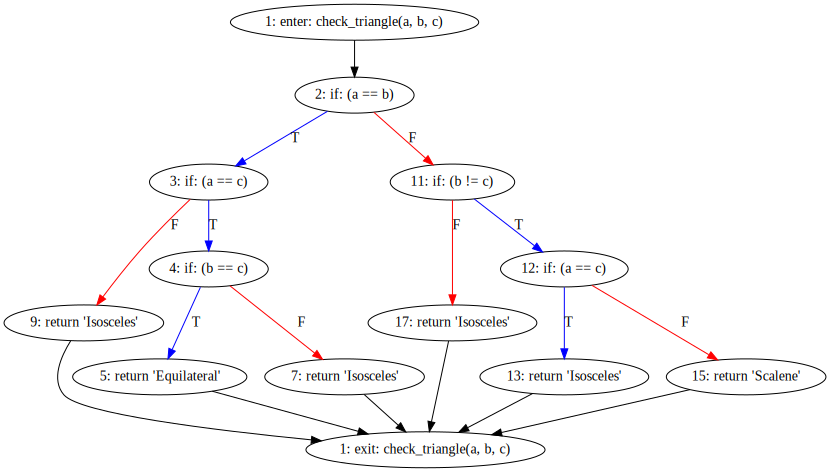

In [21]:
Source(graph)

#### cgi_decode

Note that we do not yet support _augmented assignments_: i.e assignments such as `+=`

In [22]:
def cgi_decode(s):
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ""
    i = 0
    while i < len(s):
        c = s[i]
        if c == '+':
            t = t + ' '
        elif c == '%':
            digit_high, digit_low = s[i + 1], s[i + 2]
            i = i + 2
            if digit_high in hex_values and digit_low in hex_values:
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t = t + chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t = t + c
        i = i + 1
    return t

In [23]:
graph = to_graph(gen_cfg(inspect.getsource(cgi_decode)))

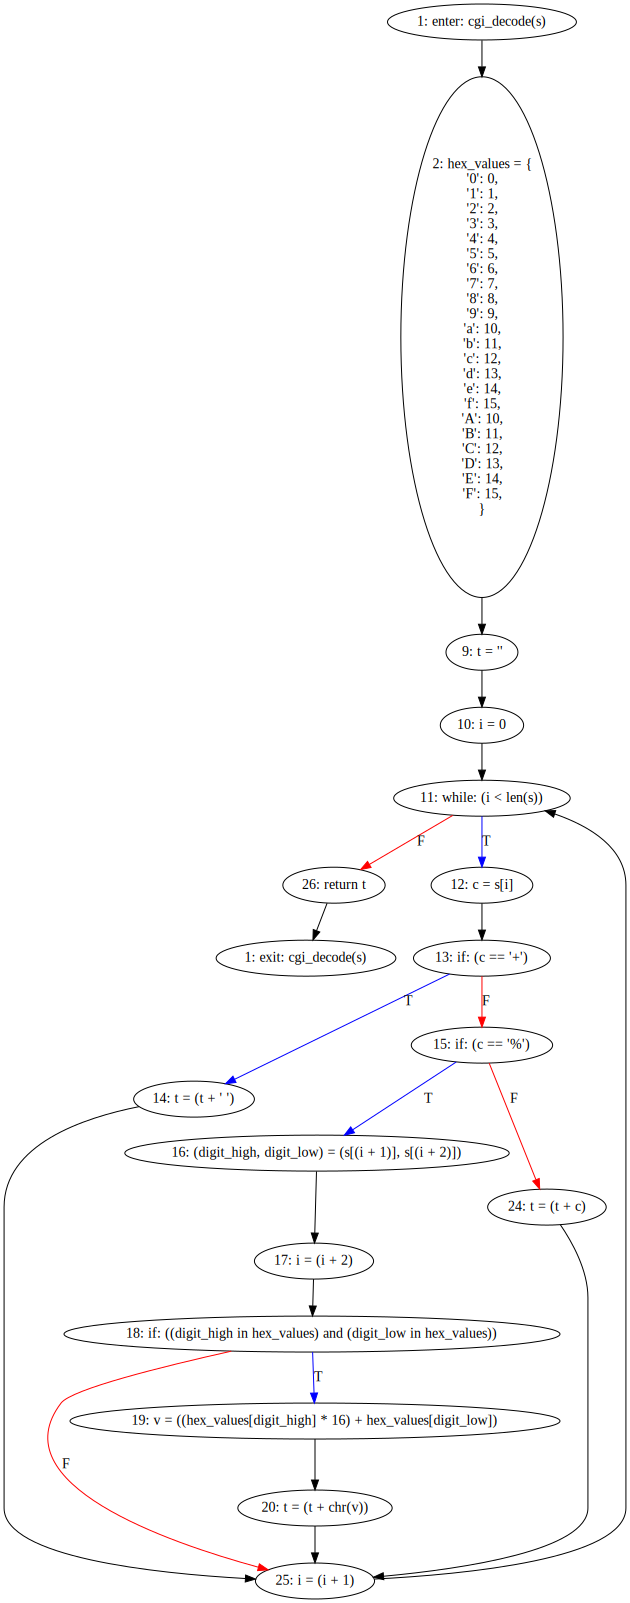

In [24]:
Source(graph)

#### gcd

In [25]:
def gcd(a, b):
    if a<b:
        c = a
        a = b
        b = c

    while b != 0 :
        c = a
        a = b
        b = c % b
    return a

In [26]:
graph = to_graph(gen_cfg(inspect.getsource(gcd)))

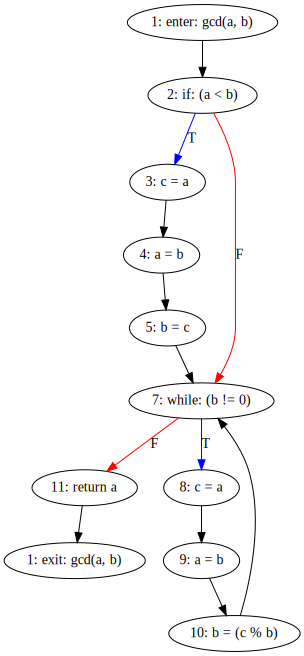

In [27]:
Source(graph)

In [28]:
def compute_gcd(x, y): 
  
    if x > y: 
        small = y 
    else: 
        small = x 
    for i in range(1, small+1): 
        if((x % i == 0) and (y % i == 0)): 
            gcd = i 
              
    return gcd 

In [29]:
graph = to_graph(gen_cfg(inspect.getsource(compute_gcd)))

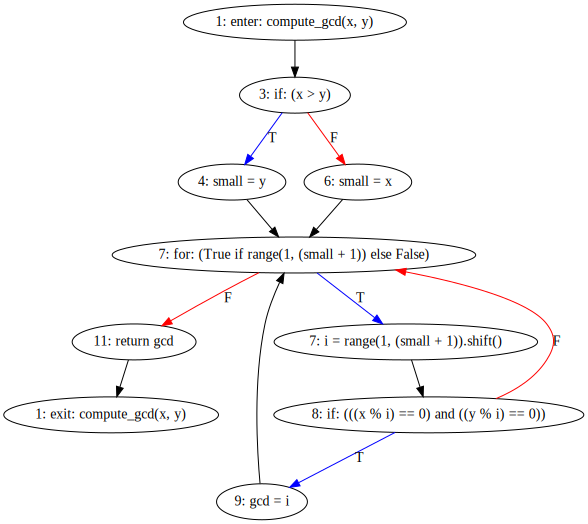

In [30]:
Source(graph)

#### fib

Note that the *for-loop* requires additional massaging. While we show the labels correctly, the *comparison node* needs to be extracted. Hence, the representation is not accurate.

In [31]:
def fib(n,):
    l = [0, 1]
    for i in range(n-2):
        l.append(l[-1]+l[-2])
    return l

In [32]:
graph = to_graph(gen_cfg(inspect.getsource(fib)))

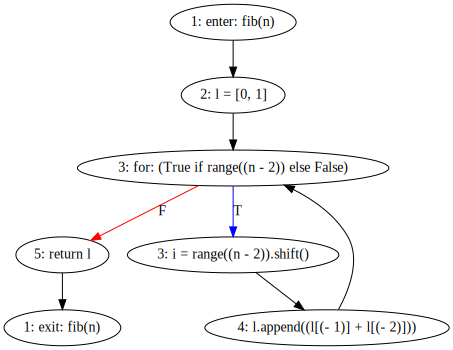

In [33]:
Source(graph)